In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
from collections import defaultdict


data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')
data_india_population = pd.read_excel('../Case/India Population (2011).xlsx')

In [30]:
data_india_diabetes = pd.read_excel('../Case/ICMR-INDIAB Study.xlsx')

get_lower = lambda x: [float(i.split(" ")[1][1:-1].split("–")[0]) for i in x]
get_upper = lambda x: [float(i.split(" ")[1][1:-1].split("–")[1]) for i in x]
get_mean = lambda x: [float(i.split(" ")[0]) for i in x]

def add_cols(data,cols):
    for col in cols:
        data.insert(1, f"{col} Max", get_upper(data[col]))
        data.insert(1, f"{col} Min", get_lower(data[col]))
        data.insert(1, f"{col} Mean", get_mean(data[col]))
        data.drop(col, axis=1, inplace=True)
    return data
data3 = add_cols(data_india_diabetes, ["Abdominal Obesity", "Generalized Obesity", "Hypertension", "Prediabetes", "Diabetes"])
data3.to_excel("ICMR-INDIAB_modified.xlsx")

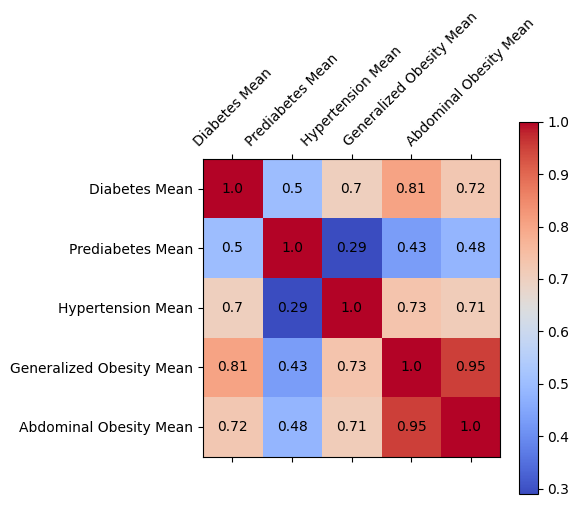

In [31]:
data1 = pd.read_excel("ICMR-INDIAB_modified.xlsx", index_col=0)
cols = ["Diabetes Mean", "Prediabetes Mean", "Hypertension Mean", "Generalized Obesity Mean", "Abdominal Obesity Mean"]
# with cols as labels:
plt.matshow(data1[cols].corr(), cmap='coolwarm')
plt.yticks(range(len(cols)), cols, rotation=0)
plt.xticks(range(len(cols)), cols, rotation=45)
# include numbers in the heatmap
for i in range(len(cols)):
    for j in range(len(cols)):
        plt.text(j, i, round(data1[cols].corr().values[i, j], 2), ha='center', va='center', color='black')
# make legend
plt.colorbar();

In [32]:
import pickle

# Load with:
with open("../Lucas/countries_population.pickle", "rb") as file:
    loaded_population_dict = pickle.load(file)
    
with open("../Lucas/countries_estimation.pickle", "rb") as file:
    loaded_estimation_dict = pickle.load(file)
    
loaded_population_dict["Côte d'Ivoire"] = loaded_population_dict["Ivory Coast"]
loaded_estimation_dict["Côte d'Ivoire"] = loaded_estimation_dict["Ivory Coast"]
loaded_population_dict.pop("Ivory Coast")
loaded_estimation_dict.pop("Ivory Coast")

loaded_population_dict["Guinea"] = loaded_population_dict["Guinea-Conakry"]
loaded_estimation_dict["Guinea"] = loaded_estimation_dict["Guinea-Conakry"]
loaded_population_dict.pop("Guinea-Conakry")
loaded_estimation_dict.pop("Guinea-Conakry")

[(14.79691, 6000.0, 88781.46), (7.46, 6000.0, 44760.0)]

In [33]:
data_new = pd.read_excel("../Case/Health Data from International Diabetes Foundation.xlsx", index_col=0, sheet_name=None, header=1)
data_undiag = data_new["People undiagnosed (1000s)"][["Country/Territory", 2021]]
data_diag = data_new["People with diabetes (1000s)"][["Country/Territory", 2021]]



countries = loaded_population_dict.keys()
# df = pd.DataFrame(["Country", "Population", "Diagnosed", "Undiagnosed"])
df = len(countries)*[None]
for i, country in enumerate(countries):
    try:
        country_pop = loaded_population_dict[country] * 1e8
        
        country_diag = data_diag[data_diag["Country/Territory"] == country][2021].values[0]
        country_diag = float(str(country_diag).replace(",", ""))*1000 / country_pop
        
        country_undiag = data_undiag[data_undiag["Country/Territory"] == country][2021].values[0]
        country_undiag = float(str(country_undiag).replace(",", ""))*1000 / country_pop
        
        country_pop /= 1e8
        
        if country is None or country_diag is None or country_undiag is None:
            print(country, country_pop, country_diag, country_undiag)
        df[i] = [country, country_pop, country_diag, country_undiag]
    except:
        print(f"Error in {country}")
    
the_df = pd.DataFrame([i for i in df if i is not None], columns=["Country", "Population", "Diagnosed", "Undiagnosed"])
the_df.set_index("Country", inplace=True)

In [36]:
the_the_df = []
for state, projs in loaded_estimation_dict.items():
    for dollar_per_screening, _, money_spent in projs:
        pop, undiag, diag = the_df.loc[country]
        the_the_df.append([pop, diag, undiag, money_spent, dollar_per_screening])
DF = np.array(the_the_df)

In [37]:
# with open("india_states_population.pickle", "rb") as file:
#     loaded_india_pop_dict = pickle.load(file)

# df = pd.read_csv("../Alex/india_states_data.csv")
# df["MoneySpent"] = 8000000

In [38]:
DF

array([[1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 4.37305200e+04,
        1.24944343e+01],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 7.89327000e+03,
        3.94663500e+00],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 2.75814000e+03,
        1.37907000e+00],
       ...,
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 5.96800000e+04,
        7.46000000e+00],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 8.87814600e+04,
        1.47969100e+01],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 4.47600000e+04,
        7.46000000e+00]])

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = DF[:, :-1]
y = DF[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = MLPRegressor(hidden_layer_sizes=(1000, 1000, 1000, 1000), max_iter=1000)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))
y_test - y_pred

538.0681799793389


array([-9.02068478e+00,  5.12157693e+00,  1.24038889e-01, -3.39467949e-01,
       -1.66776609e+00, -3.89796432e+00, -3.62876968e+00,  7.60164896e-01,
        1.52890480e+02, -7.91974107e+00,  6.48588856e+00, -3.72553331e+00,
       -9.52945467e-02,  2.41496279e+01,  9.52681249e-02, -3.10832121e+00,
       -4.63498423e+00,  1.80277050e+00, -2.33631312e+00, -2.16887559e-01,
       -3.39496958e+00,  1.51962527e-01, -1.50365816e+00,  2.95832228e+01,
        2.70539643e+00, -2.15395504e+01, -6.08661117e+00,  4.18049082e+00,
        1.17730313e+01, -4.20048667e-01,  2.38255017e+00, -7.21006242e+00,
       -9.05490177e+00, -2.11228920e+00,  6.54193804e+00,  1.19810567e-01,
       -1.85038586e+00, -8.40106333e+00,  1.92933847e+00, -1.95896273e+00,
       -1.52625985e+00, -6.19177195e-02, -1.59621142e+01, -2.11015455e+00,
       -6.18059449e+00,  4.34041663e+00, -1.60171029e+01, -1.90540164e+00,
        2.42359077e+00, -1.54905570e+01])

In [40]:
X_train

array([[1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 8.44614540e+05],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 2.44906200e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 6.52004000e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 2.57817600e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 1.24254900e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 2.46708000e+03],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 5.42043600e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 5.58716700e+05],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 2.06791200e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 9.66665700e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 7.27650000e+03],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 7.97847000e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e-03, 4.91241000e+04],
       [1.31327920e-01, 4.54587265e-03, 7.89626456e

In [41]:
import torch
import torch.nn as nn
import torch.optim as op
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = "cpu"

class RegressorModule(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # simple feedforward layers
        self.layers.append(
            nn.Sequential(
                nn.Linear(4, n_hidden),
                nn.Tanh(),
                nn.Linear(n_hidden, n_hidden*2),
                nn.Tanh(),
                nn.Linear(n_hidden*2, n_hidden),
                nn.Tanh(),
                nn.Linear(n_hidden, 1)
            )
        )

    def forward(self, X):
        for l in self.layers:
            X = l(X)
        return X

def train_model(n_hidden, lr, X_train, y_train, batch_size):
    max_steps = 2000

    model = RegressorModule(n_hidden).to(device)
    optim = op.Adam(model.parameters(), lr=lr)

    model.train()

    loss_list = []
    for step in tqdm(range(max_steps)):
        ix = torch.randint(0, len(X_train), (batch_size,))
        Xb, Yb = X_train[ix].to(torch.float32), y_train[ix].to(torch.float32)
        
        logits = model(Xb)
        loss = nn.MSELoss()(logits, Yb.view(-1, 1))
        loss_list.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return model, loss_list


In [7]:
X = DF[:, :-1]
y = DF[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

normalized_X_train=(X_train-X_train.mean())/X_train.std()
normalized_X_test=(X_test-X_test.mean())/X_test.std()
normalized_y_train=(y_train-y_train.min())/(y_train.max()-y_train.min())
normalized_y_test=(y_test-y_test.min())/(y_test.max()-y_test.min())

model,loss_list = train_model(2000, 0.00005, normalized_X_train, normalized_y_train, 64)

100%|██████████| 2000/2000 [02:29<00:00, 13.35it/s]


In [ ]:
torch.save(model.state_dict(), "model2")

In [42]:
new_model = RegressorModule(2000)
new_model.load_state_dict(torch.load("model"))
new_model.eval()

RegressorModule(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=2000, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2000, out_features=4000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=4000, out_features=2000, bias=True)
      (5): Tanh()
      (6): Linear(in_features=2000, out_features=1, bias=True)
    )
  )
)

In [43]:
# 8: 16 batch, 0.0005, 2000 hidden og 2000 max steps

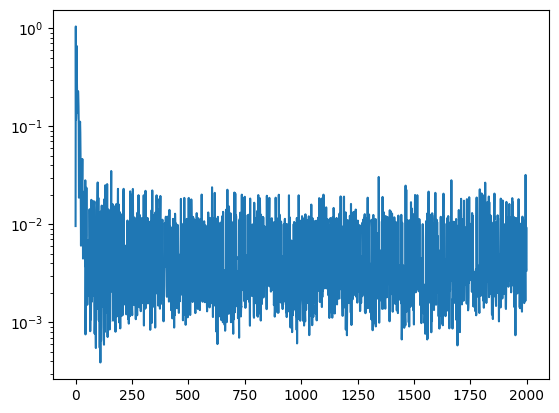

In [44]:
import matplotlib.pyplot as plt
plt.semilogy(loss_list)

In [46]:
new_model.eval()
y_out = new_model(normalized_X_test)
(y_out * (y_train.max() - y_train.min()) + y_train.min()).view(1, -1)[0]

tensor([4.6838, 4.1484, 4.3739, 4.1754, 4.3827, 4.2631, 4.1888, 4.1326, 4.2320,
        4.4225, 4.2057, 4.2941, 4.3543, 4.4550, 4.1758, 4.2472, 4.2856, 4.4426,
        4.2376, 4.0052, 4.3301, 4.0036, 4.3836, 4.2344, 4.2828, 4.8444, 4.1751,
        4.1222, 4.2780, 4.3789, 4.1997, 4.3847, 4.9115, 4.3652, 4.0055, 4.4136,
        4.4310, 4.2618, 4.1421, 4.1985, 4.3834, 4.3734, 4.5198, 4.1314, 4.1836,
        4.4612, 4.8617, 4.1157, 4.1921, 4.6169], grad_fn=<SelectBackward0>)

In [60]:
normalized_X_test

tensor([[ 0.4145, -0.2659, -0.2631, -0.2408],
        [-0.2135, -0.2623, -0.2571, -0.2679],
        [ 4.3066, -0.2595, -0.2511, -0.2625],
        [-0.1708, -0.2634, -0.2563, -0.2681],
        [ 4.3066, -0.2595, -0.2511, -0.2587],
        [-0.2018, -0.2675, -0.2665, -0.2587],
        [-0.2134, -0.2668, -0.2652, -0.2687],
        [-0.2084, -0.2588, -0.2481, -0.2636],
        [-0.2135, -0.2623, -0.2571, -0.2539],
        [ 4.3066, -0.2595, -0.2511, -0.2414],
        [-0.2134, -0.2668, -0.2652, -0.2659],
        [-0.1887, -0.2656, -0.2632, -0.2516],
        [ 4.5033, -0.2522, -0.2365, -0.2628],
        [ 0.0280, -0.2649, -0.2619, -0.2451],
        [-0.1708, -0.2634, -0.2563, -0.2681],
        [-0.2425, -0.2673, -0.2660, -0.2567],
        [-0.2522, -0.2672, -0.2659, -0.2491],
        [ 0.1223, -0.2659, -0.2636, -0.2587],
        [-0.1976, -0.2675, -0.2664, -0.2633],
        [-0.1605, -0.2469, -0.2241, -0.2684],
        [-0.1815, -0.2674, -0.2661, -0.2492],
        [-0.1605, -0.2469, -0.2241

In [47]:
y_test

array([3.85465500e+00, 1.14345000e+01, 7.73452800e+00, 5.91382212e+00,
       6.87610000e+00, 4.65383208e+00, 2.48666667e+00, 8.12196000e+00,
       1.62607500e+02, 4.81404000e+00, 1.32894571e+01, 6.53309500e+00,
       7.46000000e+00, 3.59945000e+01, 6.36360577e+00, 5.92542720e+00,
       6.23122500e+00, 1.03569667e+01, 5.08219490e+00, 5.98290000e+00,
       7.46000000e+00, 6.28320000e+00, 7.13328000e+00, 3.82536000e+01,
       1.19651231e+01, 8.92808206e+00, 1.51074000e-01, 1.14310154e+01,
       1.85754000e+01, 7.72198810e+00, 8.94134286e+00, 4.02676312e+00,
       1.45382160e+01, 1.10566525e+01, 1.27512000e+01, 1.19334600e+01,
       6.19926000e+00, 6.84080551e-01, 9.51523000e+00, 7.91630333e+00,
       7.09786000e+00, 7.50177600e+00, 6.91373562e+00, 5.19981000e+00,
       6.06606000e-01, 1.37015333e+01, 5.23416565e+00, 6.94108800e+00,
       9.22056000e+00, 5.44025382e+00])

In [50]:
with torch.no_grad():
    print(abs((y_out * (y_train.max() - y_train.min()) + y_train.min()).view(1, -1)[0] - y_test).mean())

tensor(8.1457, dtype=torch.float64)


In [58]:
with open("india_states_population.pickle", "rb") as file:
    loaded_india_pop_dict = pickle.load(file)

df = pd.read_csv("../Alex/india_states_data.csv")
df["MoneySpent"] = 80000

df

,Country,Population,Diagnosed,Undiagnosed,MoneySpent
0,Andhra Pradesh,0.539034,0.0570,0.030267,80000
1,Arunachal Pradesh,0.015705,0.0360,0.019116,80000
2,Assam,0.356070,0.0402,0.021346,80000
3,Bihar,1.247999,0.0324,0.017204,80000
4,Chandigarh,0.011796,0.1224,0.064994,80000
5,Chhattisgarh,0.294362,0.0618,0.032816,80000
6,Delhi,0.187109,0.1068,0.056711,80000
7,Goa,0.015863,0.1584,0.084110,80000
8,Gujarat,0.638724,0.0492,0.026125,80000
9,Haryana,0.289411,0.0744,0.039506,80000


In [78]:
keys = df["Country"].values
Xval = df[["Population","Diagnosed", "Undiagnosed", "MoneySpent"]].values
Xval = torch.tensor(Xval, dtype=torch.float32).to(device)
normalized_X_val=(Xval-Xval.mean(axis=0))/(Xval.std(axis=0) + 0.0001)
y_out = new_model(normalized_X_val)
outputs = (y_out * (y_train.max() - y_train.min()) + y_train.min()).view(1, -1)[0]
outputs = {k: max(o.item(), 0.3) for k, o in zip(keys, outputs)}
outputs

{'Andhra Pradesh': 6.363447666168213,
 'Arunachal Pradesh': 9.557994842529297,
 'Assam': 9.43730354309082,
 'Bihar': 9.826014518737793,
 'Chandigarh': 0.3,
 'Chhattisgarh': 5.228912353515625,
 'Delhi': 0.3,
 'Goa': 0.3,
 'Gujarat': 7.941952705383301,
 'Haryana': 2.7897462844848633,
 'Himachal Pradesh': 1.751681923866272,
 'Jharkhand': 8.944061279296875,
 'Karnataka': 5.052963733673096,
 'Kerala': 0.3,
 'Madhya Pradesh': 9.02022647857666,
 'Maharashtra': 5.291801929473877,
 'Manipur': 9.021818161010742,
 'Meghalaya': 10.300216674804688,
 'Mizoram': 7.873376846313477,
 'Nagaland': 9.57225227355957,
 'Odisha': 6.077414512634277,
 'Puducherry': 0.3,
 'Punjab': 2.467782974243164,
 'Rajasthan': 9.366660118103027,
 'Sikkim': 2.4445419311523438,
 'Tamil Nadu': 0.8371416926383972,
 'Telangana': 5.785724639892578,
 'Tripura': 3.964198112487793,
 'Uttar Pradesh': 7.564896106719971,
 'Uttarakhand': 4.200257301330566,
 'West Bengal': 1.6778894662857056}

In [93]:
new_xval = Xval[5, :3]
lst = []
for t in [8000, 10000, 20000, 80000, 100000, 200000, 800000]:
    lst.append(list(Xval[5, :3]) + [t])
    
lst = torch.tensor(lst)
normalized_X_val=(lst-Xval.mean(axis=0))/(Xval.std(axis=0) + 0.0001)
y_out = new_model(normalized_X_val)
outputs = (y_out * (y_train.max() - y_train.min()) + y_train.min()).view(1, -1)[0]
outputs

[10.2, 9.2, 8.4, 5.2, 16.2, 80.2, 89.9]

tensor([-71.8799, -71.8799, -71.8799,   5.2289,  80.8948,  80.8948,  80.8948],
       grad_fn=<SelectBackward0>)

In [79]:
with open("india_states_dkk_per_screened.pickle", "wb") as file:
    pickle.dump(outputs, file)

In [70]:
Xval.mean(axis=0), Xval.std(axis=0)

(tensor([4.3881e-01, 6.8961e-02, 3.6618e-02, 8.0000e+04]),
 tensor([0.5209, 0.0364, 0.0193, 0.0000]))

In [65]:
normalized_X_val

tensor([[-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750,  1.7251],
        [-0.5750, -0.5750, -0.5750

In [167]:
X = data1[["Hypertension Mean", "Generalized Obesity Mean", "Abdominal Obesity Mean"]].values

y = data1["Diabetes Mean"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

_combined = np.concatenate((X_train, y_train[:,np.newaxis]), axis=1)

from sdv.datasets.local import load_csvs
from sdv.metadata import MultiTableMetadata
from sdv.multi_table import HMASynthesizer
metadata = MultiTableMetadata()

# data = pd.read_csv("X.csv", index_col=0)
data = pd.read_csv("X2.csv", index_col=0)
data = {"df1": data}

metadata.detect_from_dataframes(data)
metadata.update_column(table_name='df1', column_name='0', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='1', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='2', sdtype='numerical')
metadata.update_column(table_name='df1', column_name='3', sdtype='numerical')

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(data)
synthetic_data = synthesizer.sample(1000)

X_synth = synthetic_data["df1"][["0","1","2"]]
y_synth = synthetic_data["df1"]["3"].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_synth)
X_test_scaled = scaler.transform(X_test)

# model = LinearRegression()
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

model.fit(X_train_scaled, y_synth)
y_pred = model.predict(X_test_scaled)
print(mean_squared_error(y_test, y_pred))

y_test - y_pred

ModuleNotFoundError: No module named 'sdv'

Error at project 25


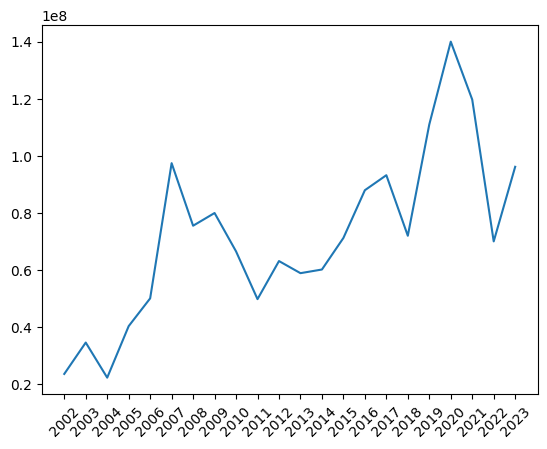

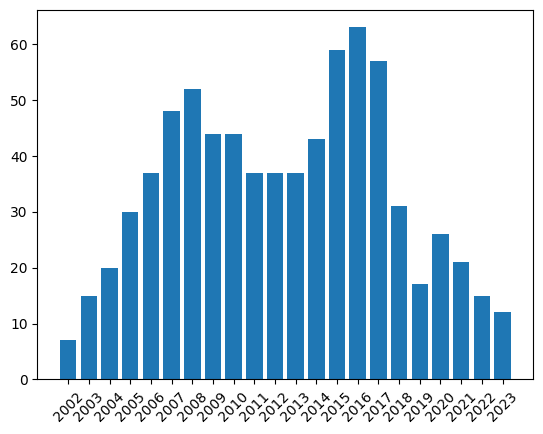

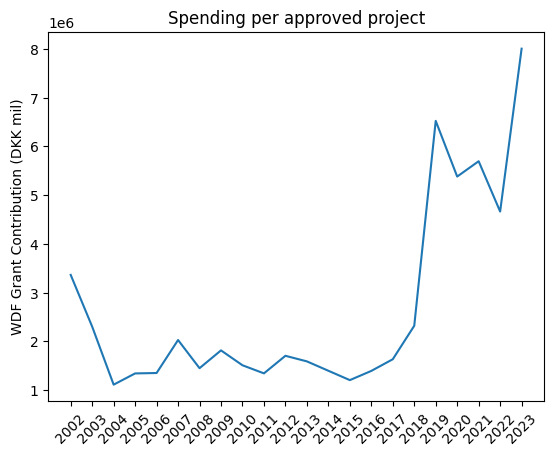

In [ ]:
def get_wdf(data):
    mask_approved = data["Board approval date"].notna()
    
    _approved_projects = np.bincount([int(re.split('-|/', i)[-1]) for i in data["Board approval date"][mask_approved]])[2002:]
    _approved_projects = np.append(_approved_projects, (22-len(_approved_projects))*[0])
    
    _dicter = {year: 0 for year in range(2002, 2024)}
    converter = {"USD": 6.93, "EUR": 7.46, "DKK": 1}
    for i, project in data[mask_approved].iterrows():
        try:
            year = int(re.split('-|/', project["Board approval date"])[-1])
            _dicter[year] += project["Total Revised WDF Contibution"] * converter[project["WDF Grant Currency"]]
        except: print(f"Error at project {i}")
        
    _approved_spending = list(_dicter.values())
    _spending_per_project = [x / (y+0.01) for x, y in zip(_approved_spending, _approved_projects)]
    return _approved_projects, _approved_spending, _spending_per_project


def plot_wdf(data):    
    plt.plot(range(2002,2024), data[1])
    plt.xticks(range(2002, 2024), rotation=45)
    plt.show()

    plt.bar(range(2002,2024), data[0])
    plt.xticks(range(2002, 2024), rotation=45)
    plt.show()

    plt.plot(range(2002,2024), data[2])
    plt.xticks(range(2002,2024), rotation=45)
    plt.title("Spending per approved project")
    plt.ylabel("WDF Grant Contribution (DKK mil)")
    plt.show()


data_wdf = pd.read_excel('../Case/Milestones Case Data.xlsx', sheet_name=None)
plot_wdf(get_wdf(data_wdf["Projects"]))

Error at project 25


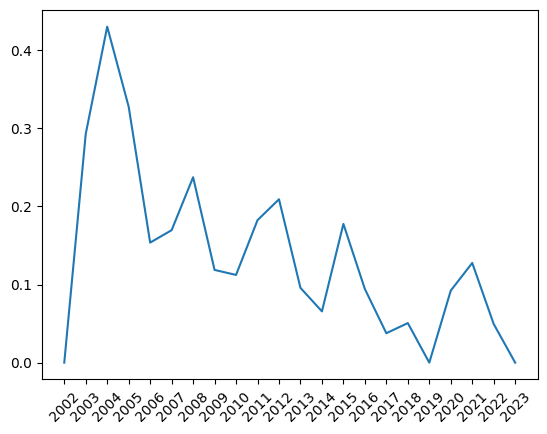

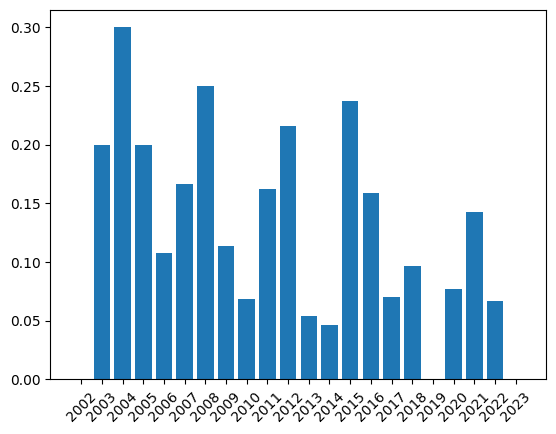

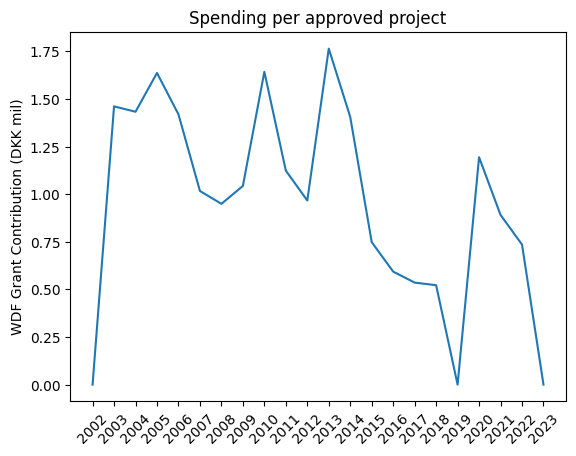

In [ ]:
data_india = data_wdf["Projects"][data_wdf["Projects"]["Countries"] == "India"]
plot_wdf([np.array(x)/np.array(y) for x,y in zip(get_wdf(data_india), get_wdf(data_wdf["Projects"]))])